In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
import os
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java


update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


Confguring Kaggle dataset

In [1]:
!pip install -q opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/kazanova/sentiment140')

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140


100%|██████████| 80.9M/80.9M [00:24<00:00, 3.46MB/s]


In [ ]:
!pip install -q findspark pyspark==3.3.0 nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 10.6 MB/s eta 0:00:00


In [2]:
#### for data manipulation and math operations ####
import pandas as pd
import numpy as np

#### for visualizations ####
# plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

#### NLP packages ####
# NLTK library
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize

#### other useful packages ####
import string
from collections import Counter
import re
from tqdm import tqdm


#### Pyspark packages ####
from pyspark.sql import functions as func
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#### Evalutions ####
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# import findspark
# findspark.init()
# findspark.find()

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Tweet").getOrCreate()
# spark.stop()
spark


In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.sql.functions import col, to_timestamp, expr
from pyspark.sql.functions import udf



In [6]:
# Load the data from HDFS
df =(spark.read
          .format('csv')
          .option('header', 'false')
          .load('sentiment140/training.1600000.processed.noemoticon.csv'))
# Show the DataFrame
df.show(truncate=False)

+---+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|_c0|_c1       |_c2                         |_c3     |_c4            |_c5                                                                                                                  |
+---+----------+----------------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|0  |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |
|0  |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|0  |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|m

In [ ]:
df.count(), len(df.columns) # Size / shape of dataset

(1600000, 6)

In [7]:
# adding columns to dataset
from pyspark.sql.functions import col, to_timestamp, expr


df = (df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','tweet_date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
)
df = df.withColumn('tweet_date', expr('substring(tweet_date, 5, 27)'))
df = df.select(col('target').cast('int'),
                         col('id').cast('int'),
                         to_timestamp(col('tweet_date'),'MMM dd HH:mm:ss zzz yyyy').alias('date'),
                         col('flag').cast('string'),
                         col('user').cast('string'),
                         col('text').cast('string'),
                        )

df.show(truncate=False)

+------+----------+-------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|target|id        |date               |flag    |user           |text                                                                                                                 |
+------+----------+-------------------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+
|0     |1467810369|2009-04-07 10:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |
|0     |1467810672|2009-04-07 10:19:49|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |
|0     |1467810917|2009-04-07 10:19:53|NO_QUERY|mattycus       |@Kenichan I dived man

In [ ]:
df.printSchema()

root
 |-- target: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



Preprocessing dataset

In [ ]:
# missing values
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()


target  id  date  flag  user  text
0       0   0     0     0     0     0

In [ ]:
# check duplicates
duplicates = df.groupBy("text").count().where("`count` > 1")

# Show duplicates
duplicates.show()

+--------------------+-----+
|                text|count|
+--------------------+-----+
|     is poorly sick |    4|
|This little tree ...|    2|
|at home with a cold |    2|
|          Hangover. |    2|
|   cant fall asleep |    2|
|           Confused |    5|
|       work all day |    9|
|@tommcfly Arwhh, ...|    2|
|marley and me is ...|    2|
|     i have a fever |    4|
|       is not okay. |    2|
|I want korean bbq...|    2|
|       lost my ipod |    2|
|    working all day |    4|
|         Exhausted. |    4|
|   missing my girls |    2|
|            soninho |    4|
|@dollforlife I do...|    2|
|@bngr Working m'd...|    2|
|I feel a cold com...|    2|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df = df.dropna()
df.count(), len(df.columns) # Size / shape of dataset after dropping NA values

(1600000, 6)

In [8]:
# drop duplicates
df = df.dropDuplicates(['text'])
df.groupBy("text").count().where("`count` > 1").show()

+----+-----+
|text|count|
+----+-----+
+----+-----+



In [ ]:
df.dtypes

[('target', 'string'),
 ('id', 'string'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

In [ ]:
# only work on text and target, to reduce baggage
drops= ("id","date","flag","user")
df = df.drop(*drops)
df.show(5, truncate = False)

+------+---------------------------------------------------------------------------------------------------+
|target|text                                                                                               |
+------+---------------------------------------------------------------------------------------------------+
|0     |                   I missed the New Moon trailer...                                                |
|0     |               just practising.....how I feel                                                      |
|0     |         i think mi bf is cheating on me!!!       T_T                                              |
|4     |       Hardest working chica i know( mii boss lady) @MoneyAceweather (look up to her seriously) lOl|
|4     |       Juuuuuuuuuuuuuuuuussssst Chillin!!                                                          |
+------+---------------------------------------------------------------------------------------------------+
only showing top 5 

In [9]:
# change column target from 4 to 1 and rename it to 'label'
df = df.withColumnRenamed('target', 'label')
df = df.withColumn('label', func.when(df.label == 4, 1).otherwise(df.label))
df.select('label').distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



Text Clean Cell **Minimized as it was done in previous part**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
spark.conf.set("spark.sql.execution.pythonUDF.arrow.enabled", "false")

# decorator for udf
@udf(returnType=StringType())
def preprocess(text, stem=False):
    # Remove link,user and special characters
    word_tokens = word_tokenize(text)
    # filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words and w.isalpha()]
    filtered_sentence = []
    for word in word_tokens:
        word = re.sub(text_cleaning_re, ' ', word)
        if word not in stop_words:
            filtered_sentence.append(word)
        if stem == True:
            filtered_sentence.append(stemmer.stem(word))

    return " ".join(filtered_sentence)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# preprocess = udf(preprocess, StringType())
df = df.withColumn('text_cleaned',preprocess(df.text))

In [ ]:
df.show(5, truncate = False)

+-----+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|label|text                                                                                               |text_cleaned                                                                         |
+-----+---------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+
|0    |                   I missed the New Moon trailer...                                                |I missed New Moon trailer                                                            |
|0    |               just practising.....how I feel                                                      |practising   I feel                                                                  |
|0    |         i think mi bf 

# EDA and Visualizations

In [10]:
# distribution of sentiments
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|791281|
|    0|790185|
+-----+------+



In [11]:
# convert df to train for pandas dataframe
train = df.toPandas()
class_group_counts = train.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_group_counts.style.background_gradient(cmap='Blues')

In [15]:
# Bar Chart for Distribution of Data in accordance to Sentiment classes.

import plotly.graph_objs as go

# create the trace
trace = go.Bar(
    x = class_group_counts['label'],
    y = class_group_counts['text'],
    marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                 line=dict(color='rgb(0,0,0)',width=1.5)),
    text = class_group_counts['text'],
    )

data = [trace]
layout = go.Layout(barmode = "group",title='Sentiment Distribution')

fig = go.Figure(data = data, layout = layout)
fig.show()

In [16]:
# Pie Chart for Distribution of Data in accordance to Sentiment classes.


import plotly.graph_objs as go

# create the trace
trace = go.Pie(
    labels = class_group_counts.label,
    values = class_group_counts.text
)

data = [trace]
layout = go.Layout(title="Pie plot of the distribution of the categorical classes")

fig = go.Figure(data = data,layout=layout)
fig.show()

c:\Users\druzm\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\druzm\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


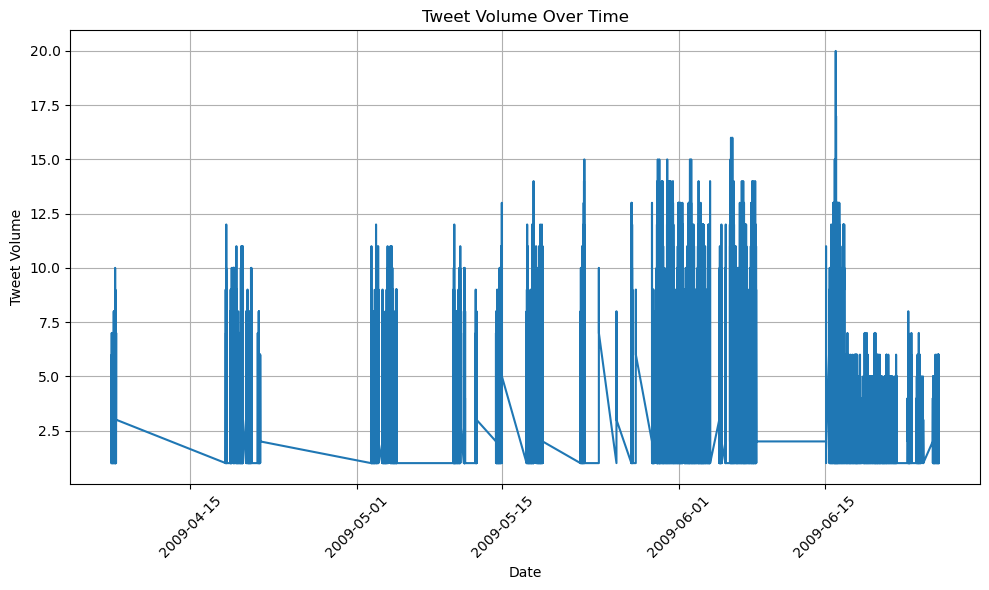

In [12]:
# Group by date and count the number of tweets per day
tweet_count_per_day = df.groupBy("date").count().orderBy("date")

# Convert Spark DataFrame to Pandas DataFrame for plotting
tweet_count_per_day_pd = tweet_count_per_day.toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=tweet_count_per_day_pd, x='date', y='count')
plt.xlabel('Date')
plt.ylabel('Tweet Volume')
plt.title('Tweet Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.grid(True)
plt.show()


<Axes: title={'center': 'Top 10 words in text before removing stop words'}, xlabel='text'>

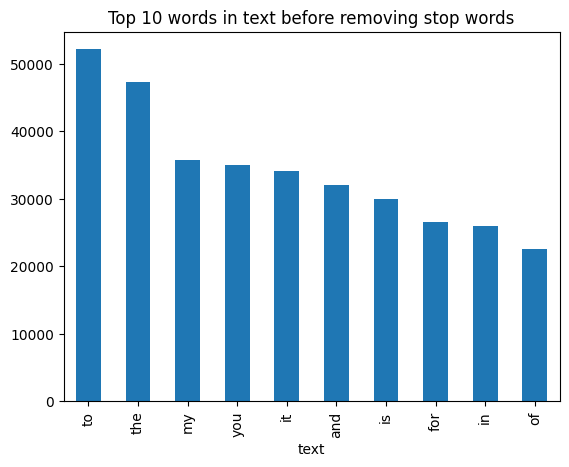

In [ ]:
# top 10 most frequent words in the dataset
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(train['text'], 10)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 10 words in text before removing stop words')


In [ ]:
# User engagement metrics
# Average length of tweet
train['text_len'] = train['text'].apply(len)
train['text_len'].describe()


count    1.581466e+06
mean     7.442700e+01
std      3.615449e+01
min      6.000000e+00
25%      4.400000e+01
50%      7.000000e+01
75%      1.040000e+02
max      3.590000e+02
Name: text_len, dtype: float64

# visualisations firectly from spark dataframe: df


<Axes: title={'center': 'Average length of tweet'}, ylabel='Frequency'>

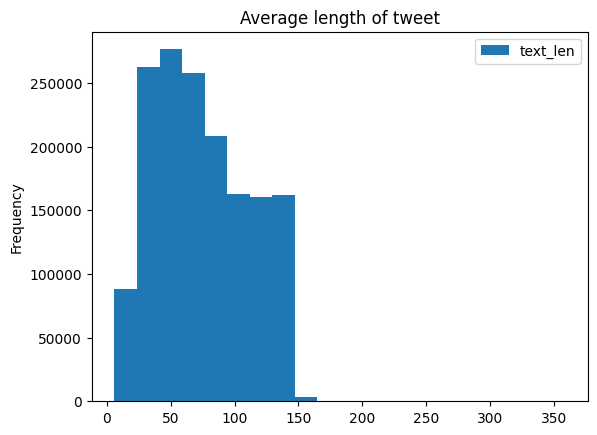

In [ ]:
train= train.drop('text_len', axis=1)
# Average length of tweet
dfv = df.toPandas()
dfv['text_len'] = dfv['text'].apply(len)
dfv.plot(kind='hist', y='text_len', bins=20, title='Average length of tweet')

<Axes: title={'center': 'Average word length'}, ylabel='Frequency'>

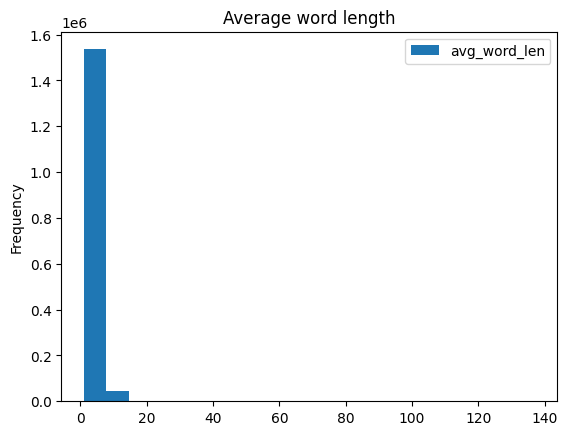

In [ ]:
# Average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

dfv['avg_word_len'] = dfv['text'].apply(avg_word)
dfv.plot(kind='hist', y='avg_word_len', bins=20, title='Average word length')

In [ ]:
df = df.drop('text')

# Wordcloud

In [ ]:
!pip install -q wordcloud

from wordcloud import WordCloud

pandas_df = df.toPandas()
pandas_df.head()

# Pos Sentiments Wordcloud

In [ ]:
pandas_df['label'] = pandas_df['label'].astype(int)
pandas_df['text_cleaned'] = pandas_df['text_cleaned'].astype(str)

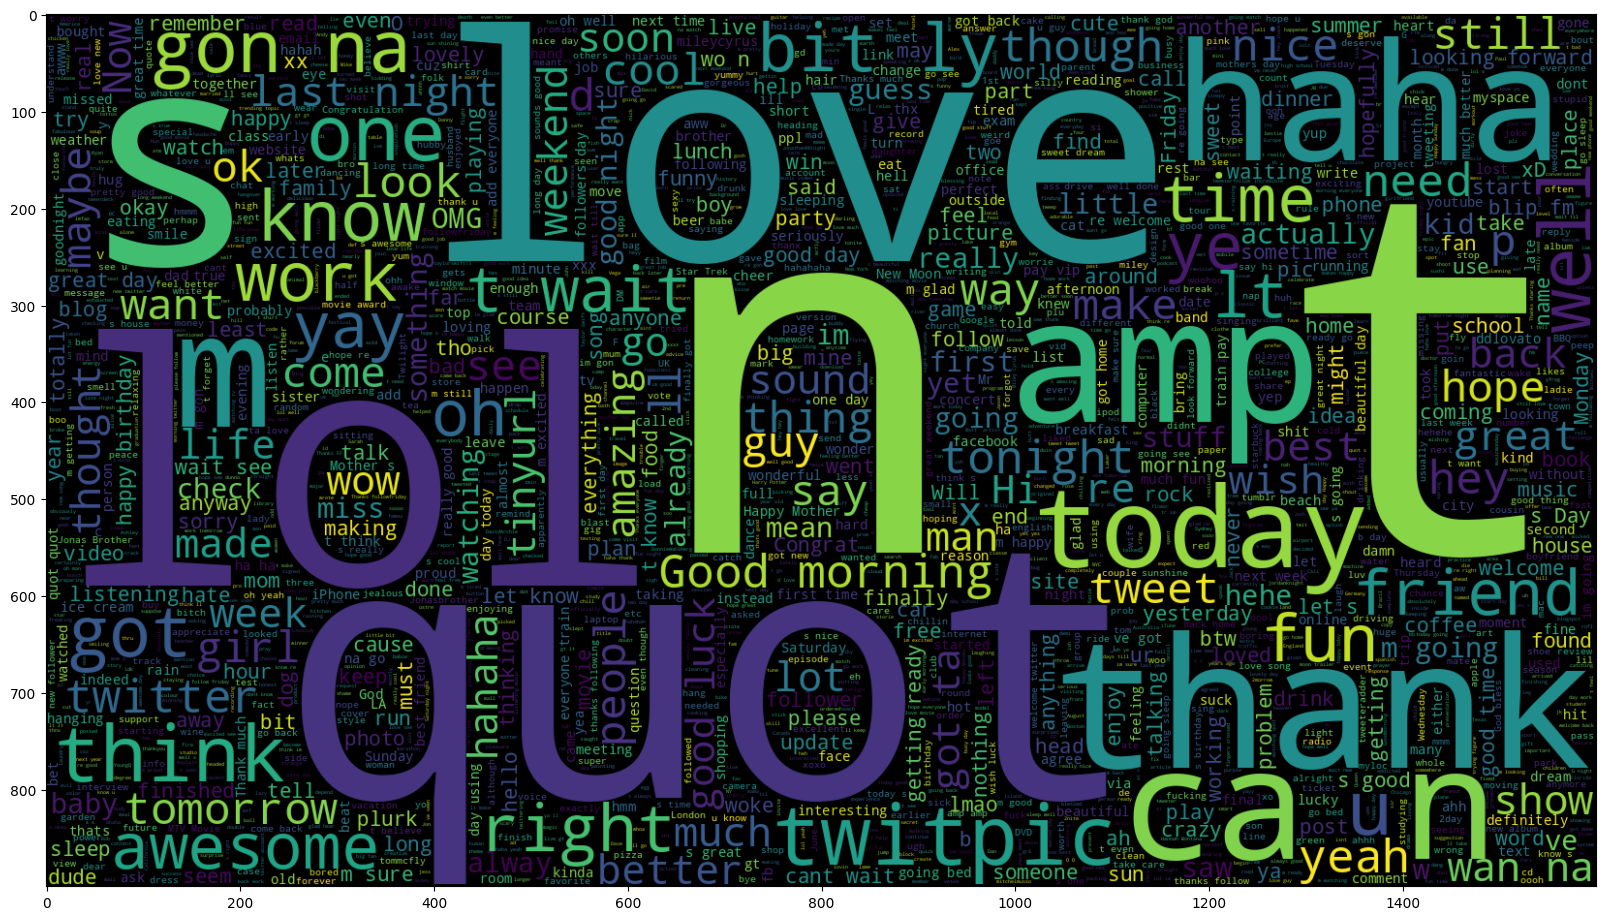

In [ ]:
plt.figure(figsize = (20,16))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Neg Sentiments Wordcloud

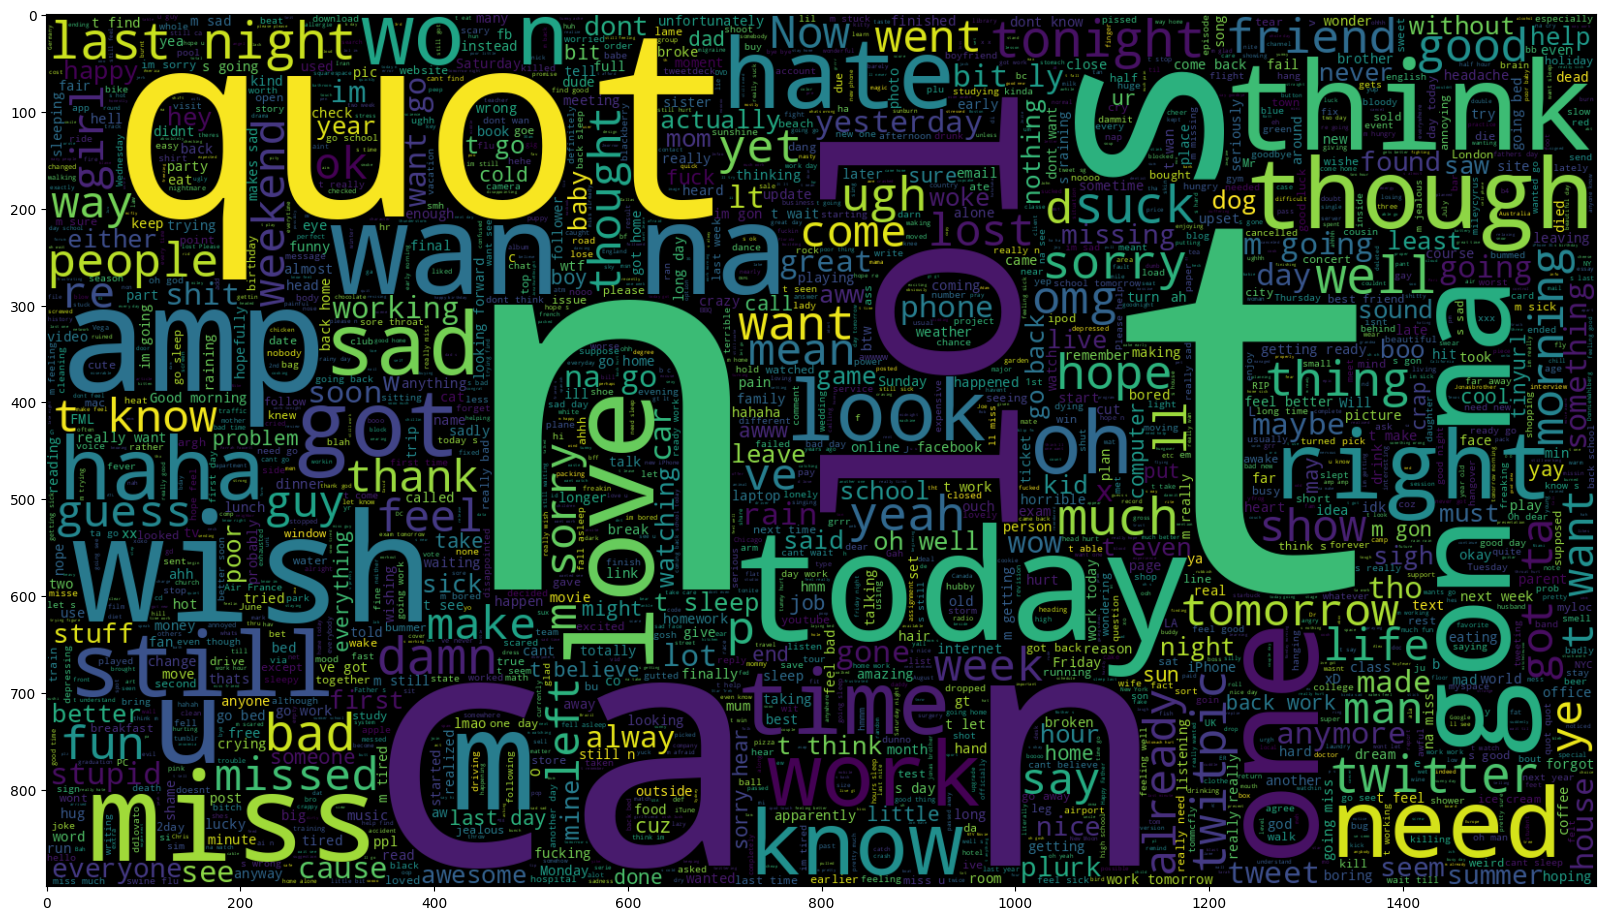

In [ ]:
plt.figure(figsize = (20,16))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

# Prepare data for modelling
## Tokenization, Stopwords removal, TF-IDF

In [ ]:
df = df.withColumn("label", col("label").cast("int"))
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_toks")
words_toks = tokenizer.transform(df)
words_toks.show(5, truncate = False)

+-----+-------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|label|text_cleaned                                                                         |words_toks                                                                                                 |
+-----+-------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|0    |I missed New Moon trailer                                                            |[i, missed, new, moon, trailer]                                                                            |
|0    |practising   I feel                                                                  |[practising, , , i, feel]                                                                          

In [ ]:
vectorizer = CountVectorizer(inputCol="words_toks", outputCol="raw_features")
model = vectorizer.fit(words_toks)
featurizedData = model.transform(words_toks)
featurizedData.show(5, truncate = False)

+-----+-------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+
|label|text_cleaned                                                                         |words_toks                                                                                                 |raw_features                                                                                         |
+-----+-------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+
|0    |I missed New Moon trailer                                                        

In [ ]:
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.select ("label", "features").show(5, truncate = False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                       |
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |(262144,[1,35,195,729,1219],[1.2062435277009051,3.662882128440939,4.98480432855636,6.350877496532738,7.001465062673888])                                                                                 

In [ ]:
df_scaled = rescaledData.select("label", "features")

In [ ]:
seed = 42
train_df, test_df = df_scaled.randomSplit([0.7, 0.3], seed=seed)

In [ ]:
train_df.count(), test_df.count()

(1107588, 473878)

In [ ]:
train_df.show(5, truncate = False)

+-----+--------------+
|label|features      |
+-----+--------------+
|0    |(262144,[],[])|
|0    |(262144,[],[])|
|0    |(262144,[],[])|
|0    |(262144,[],[])|
|0    |(262144,[],[])|
+-----+--------------+
only showing top 5 rows



In [ ]:
train_df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|554521|
|    0|553067|
+-----+------+



# Creating the model

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
model = lr.fit(train_df)

In [ ]:
predictions = model.transform(test_df)

In [ ]:
preds = predictions.toPandas()
preds.head()

label                                           features  \
0      0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                               rawPrediction  \
0  [-0.2016497256021339, 0.2016497256021339]   
1  [-0.2016497256021339, 0.2016497256021339]   
2  [-0.2016497256021339, 0.2016497256021339]   
3  [-0.2016497256021339, 0.2016497256021339]   
4  [-0.2016497256021339, 0.2016497256021339]   

                               probability  prediction  
0  [0.449757701920564, 0.5502422980794359]         1.0  
1  [0.449757701920564, 0.5502422980794359]         1.0  
2  [0.449757701920564, 0.5502422980794359]         1.0  
3  [0.449757701920564, 0.5502422980794359]         1.0  
4  [0.449757701920564, 0.5502422980794359]         1.0

# Model Evaluation

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC')

In [ ]:
areaUnderROC = evaluator.evaluate(predictions)
print(f"The testing areaUnderROC of our Logistic Regression model is: {areaUnderROC}")

The testing areaUnderROC of our Logistic Regression model is: 0.8078840836167808


In [ ]:
y_true = preds['label'].astype('float')
y_pred = preds['prediction']
y_true.value_counts()

label
0.0    237118
1.0    236760
Name: count, dtype: int64

In [ ]:
y_pred.value_counts()

prediction
1.0    239940
0.0    233938
Name: count, dtype: int64

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.75      0.76    237118
         1.0       0.75      0.76      0.76    236760

    accuracy                           0.76    473878
   macro avg       0.76      0.76      0.76    473878
weighted avg       0.76      0.76      0.76    473878



In [ ]:
print(accuracy_score(y_true, y_pred))

0.7573552686556455


<Axes: >

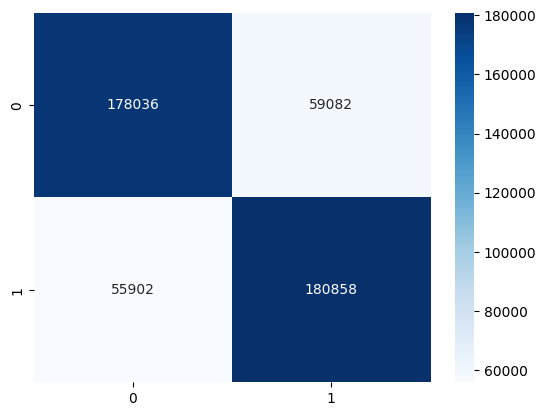

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', cmap='Blues')